In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set(color_codes=True)
sns.set_context('paper')

from tqdm import tqdm
from sstudentt import SST

# adding Automated_Update to the system path
import sys
sys.path.insert(0, 'C:\\Users\\chris\\Documents\\GitHub\\RL-and-Cryptocurrencies\\cryptoportfolio\\data')

from data_utils import crash_seeds
from data_utils import origin
#from data_utils import sampling
from data_utils import statistics
from data_utils import TI_calculation

In [6]:
crash_parameters = pd.read_csv("crash_parameters/2018.csv", header=1)
crash_parameters

,coin,crash_seed_index,start,end,close_mu,close_sigma,close_nu,close_tau,low_mu,low_sigma,...,low_tau,high_mu,high_sigma,high_nu,high_tau,open_mu,open_sigma,open_nu,open_tau,epsilon
0,BTC,7,9300,18000,2,1.5,1.0,2.5,2.5,2,...,2.3,2.5,2,10,2.2,2,1.0,1.069,2.4,0.13
1,XRP,17,9799,18499,1,1.0,1.1,2.3,2.0,1,...,2.5,2.5,2,10,2.3,2,1.0,1.100,2.3,0.13
2,ETH,10,10023,18723,1,1.0,1.0,3.0,2.5,2,...,2.3,2.5,2,10,2.5,1,1.0,1.000,3.0,0.11
3,BCH,2,1285,9985,1,1.0,1.0,2.3,2.5,2,...,2.3,2.5,2,10,2.3,1,1.0,1.000,2.3,0.10
4,ADA,25,356,9056,1,1.0,1.0,3.3,2.5,2,...,2.3,2.5,2,10,2.3,1,1.5,1.000,3.3,0.13
5,NEO,1,1361,10061,1,1.0,1.0,2.4,2.5,2,...,2.3,2.5,2,10,2.3,1,1.0,1.000,2.4,0.13
6,XLM,14,9782,18482,1,1.5,1.0,3.5,2.5,2,...,2.4,2.5,2,10,2.3,1,1.5,1.000,3.5,0.13
7,LTC,19,9408,18108,1,1.0,1.0,3.1,2.5,2,...,2.4,2.5,2,10,2.5,1,1.0,1.000,3.1,0.11
8,EOS,6,1832,10532,1,1.0,1.0,2.2,2.5,2,...,2.4,2.5,2,10,2.5,1,1.5,1.000,3.8,0.12
9,MIOTA,21,33,8733,1,1.0,1.0,3.5,2.5,2,...,2.4,2.5,2,10,3.5,1,1.5,1.000,2.8,0.13


In [7]:
class CrashPortfolio:
    """
        A crash portfolio containing all the instances of the SyntheticCoin class.    
    """
    
    def __init__(self):
        self.parameters = []
        self.portfolio = {}
        
    def generate_portfolio(self, filename=None, plot=False):
        """ Takes a filename as an argument and generates a portfolio 
            following the parameters of the file. The portfolio is a dictionary
            where the arguments are the names of the coins (e.g. "BTC") and the values 
            are the OHCL prices of the coin. """
            
        assert filename is not None, "No filename was given."
        self.parameters = pd.read_csv(filename, header=1)
        
        # Builds the portfolio
        for index, row in self.parameters.iterrows():
            coin = SyntheticPortfolio(row)
            self.portfolio[f"{row['coin']}"] = coin.generate_OHCL_prices(plot=plot)
            
    def plot(self, lw=.5, alpha=.8):
        
        for key, value in self.portfolio.items():     
            plt.title("Synthetic " + key)
            plt.plot(value["low"], label="low", lw=lw, alpha=alpha)
            plt.plot(value["open"], label="open", lw=lw, alpha=alpha)
            plt.plot(value["high"], label="high", lw=lw, alpha=alpha)
            plt.plot(value["close"], label="close", lw=lw, alpha=alpha)
            plt.legend()
            plt.show()

class SyntheticPortfolio:
    """ 
        A member of the portfolio of the CrashPortolio class.
    
        coin : pd.Series
        A row for a particular crypto currency from the chosen crash_parameters___.csv file.
    """
    
    def __init__(self, coin):
        assert type(coin) is pd.core.series.Series, "Coin must be of type pd.core.series."
        self.coin = coin
        self.ohcl_prices = pd.DataFrame()
    
    def generate_OHCL_prices(self, statistics=False, plot=False):
        """ Generates OHCL prices of a simulated crash for a given crypto currency """

        # Loading the real crash data
        crash_real, crash_length = self.load_data()
        starting_price = crash_real["close"][0]
        
        # Generate closing prices
        closing_prices = self.generate_closing_prices(crash_real, crash_length, starting_price)
            
        # Calculating all necessary distributions
        dist_low, dist_high, dist_open = self.calculate_distributions(crash_real)
                
        # Calculating low-, high-, and opening prices from closing prices
        low_prices, high_prices, opening_prices = self.calculate_OHL_prices(closing_prices, 
                                                                       dist_low, dist_high, dist_open)
         
        # Collecting all OHCL prices into a single Dataframe
        data = {"close": closing_prices, "high": high_prices,
                "low": low_prices, "open": opening_prices}
        self.ohcl_prices = pd.concat(data, axis = 1)   
        
        # Calculating the technical indicators
        self.ohcl_prices = TI_calculation(self.ohcl_prices)
        
        if statistics == True:
            self.price_statistics(crash_real)
           
        if plot == True:
            self.plot_OHCL()
        
        return self.ohcl_prices

    def load_data(self):
        
        real_data = pd.read_csv(f'../raw/{self.coin["coin"]}_USDT_{origin[self.coin["coin"]]}_1h.csv')
        crash_real = real_data.iloc[self.coin["start"]:self.coin["end"]].reset_index(drop=True)
        crash_length = self.coin["end"] - self.coin["start"]
        
        return crash_real, crash_length

    def generate_closing_prices(self, crash_real, crash_length, starting_price):
        
        np.random.seed(crash_seeds[self.coin["crash_seed_index"]])

        returns_close_real = (crash_real["close"]).pct_change().dropna()
        
        # Generating the close prices from a skewed student-t distribution
        dist_close = SST(mu = returns_close_real.mean()/self.coin["close_mu"], 
                        sigma = returns_close_real.std()/self.coin["close_sigma"], 
                        nu = self.coin["close_nu"], tau = self.coin["close_tau"]) # nu > 1 results in skewness > 0 and vice versa
                                                                    # tau >! 2, the closer to 2 the more kurtosis
                                            
        # Samples randomly from the generated distribution to get the closing prices
        returns_close_syn = dist_close.r(crash_length) # +1 ?? (len of real and syn are sometimes not equal!)

        # Generate prices
        closing_prices = pd.Series(starting_price*(1+returns_close_syn).cumprod())
        
        return closing_prices

    def calculate_distributions(self, crash_real):
        
        # -------- Low -------- #
        np.random.seed(crash_seeds[self.coin["crash_seed_index"]])
        
        percentage_deviations_low_real = (crash_real["close"] - crash_real["low"]) / crash_real["low"]

        # Distribution of low - close values
        dist_low = SST(mu =  percentage_deviations_low_real.mean()/self.coin["low_mu"],         
                    sigma = percentage_deviations_low_real.std()/self.coin["low_sigma"],
                        nu = self.coin["low_nu"], tau = self.coin["low_tau"])
            
        # ------- High ------- #
        # Generating the high distribution
        np.random.seed(crash_seeds[self.coin["crash_seed_index"]])

        percentage_deviations_high_real = ((crash_real["high"] - crash_real["close"]) / crash_real["close"]) # for high prices

        # Distribution of high - close values
        dist_high = SST(mu =  percentage_deviations_high_real.mean()/self.coin["high_mu"], 
                        sigma = percentage_deviations_high_real.std()/self.coin["high_sigma"],
                        nu = self.coin["high_nu"], tau = self.coin["high_tau"])

        # ------- Open ------- #
        np.random.seed(crash_seeds[self.coin["crash_seed_index"]])

        percentage_deviations_open_real = ((crash_real["close"] - crash_real["open"]) / crash_real["open"]) # for high prices

        # Estimating the distribution of open - close values
        dist_open = SST(mu =  percentage_deviations_open_real.mean()/self.coin["open_mu"], 
                        sigma = percentage_deviations_open_real.std()/self.coin["open_sigma"],
                        nu = self.coin["open_nu"], tau = self.coin["open_tau"])
        
        return dist_low, dist_high, dist_open

    def calculate_OHL_prices(self, closing_prices, dist_low, dist_high, dist_open):
        """ Calculates opening-, high-, and low prices from the closing prices """
        
        low_prices, high_prices, opening_prices = [], [], []
        np.random.seed(crash_seeds[self.coin["crash_seed_index"]])
        epsilon = self.coin["epsilon"]

        # Calculating the synthetic low-, high-, and opening prices from the closing prices for every time step
        for i in tqdm(range(len(closing_prices))):
            
            """ opening prices"""
            if i == 0 or i == len(closing_prices)-1: 
                # First and last value since there is no respective closing value
                open_value = closing_prices[i] / (dist_open.r(1)[0] + 1)
                opening_prices.append(open_value)
            else:
                # Open value is the closing value from the previous hour
                # There can be deviations greater than epsilon that naturally occur during the crash
                open_value = closing_prices[i-1]
                opening_prices.append(open_value)
                
            """ low prices"""    
            # Randomly sample value from the distribution and calculate the low value
            low_value = closing_prices[i] / (self.sampling(dist_low, epsilon) + 1)
            
            # The low value must always be the min value for every respective time step
            while low_value > opening_prices[i]:
                # not possible to reach the necessary deviation because epsilon cuts off distribution
                if (closing_prices[i] - opening_prices[i]) / opening_prices[i] > epsilon: 
                    # Simply accept the low value as the opening price at the current time step
                    low_value = opening_prices[i]
                else:
                    # Sample again until the low value is between the opening value and epsilon
                    # potential bottleneck if epsilon is chosen very small
                    # because probability of choosing necessary value becomes increasingly smaller  
                    low_value = closing_prices[i] / (self.sampling(dist_low, epsilon) + 1)
            low_prices.append(low_value)
            
            """ high prices"""
            # Randomly sample value from the distribution and calculate the high value
            high_value = closing_prices[i] * (self.sampling(dist_high, epsilon) + 1)
            
            # The high value must always be the max value for every respective hour
            while high_value < opening_prices[i]:
                # not possible to reach the necessary deviation because epsilon cuts off distribution
                if (opening_prices[i] - closing_prices[i]) / closing_prices[i] > epsilon:
                    # Simply accept the high value as the opening price at the current time step
                    high_value = opening_prices[i]
                else:
                    # Sample again until the high value is between the opening value and epsilon
                    # potential bottleneck if epsilon is chosen very small
                    # because probability of choosing necessary value becomes increasingly smaller
                    high_value = closing_prices[i] * (self.sampling(dist_high, epsilon) + 1)  
            high_prices.append(high_value)  

        opening_prices = pd.Series(opening_prices)
        high_prices = pd.Series(high_prices)
        low_prices = pd.Series(low_prices)
        
        return low_prices, high_prices, opening_prices

    def price_statistics(self, crash_real):
        """ Statistics for the generated prices series """
        
        prices = {"close":self.ohcl_prices["close"],"open":self.ohcl_prices["open"],
                  "high":self.ohcl_prices["high"],"low":self.ohcl_prices["low"]}

        for price, series in prices.items():
            print("\nComparison of", price, ":")
            
            returns_real = (crash_real[price]).pct_change().dropna() # for single price series
            returns_syn = (series).pct_change().dropna() # for single price series

            statistics(returns_real, returns_syn)
            
            if price == "high":
                percentage_deviations_high_real = (crash_real["high"] - crash_real["close"]) / crash_real["close"] # for high prices
                percentage_deviations_high_syn = (self.ohcl_prices["high"] - self.ohcl_prices["close"]) / self.ohcl_prices["close"] # for high prices

                statistics(percentage_deviations_high_real, percentage_deviations_high_syn)
                
            elif price == "low":
                percentage_deviations_low_real = (crash_real["close"] - crash_real["low"]) / crash_real["low"] # for high prices
                percentage_deviations_low_syn = (self.ohcl_prices["close"] - self.ohcl_prices["low"]) / self.ohcl_prices["low"] # for high prices

                statistics(percentage_deviations_high_real, percentage_deviations_high_syn)

    def plot_OHCL(self, lw=.5, alpha=.8):
        
        plt.title("Synthetic Data")
        plt.plot(self.ohcl_prices["low"], label="low", lw=lw, alpha=alpha)
        plt.plot(self.ohcl_prices["open"], label="open", lw=lw, alpha=alpha)
        plt.plot(self.ohcl_prices["high"], label="high", lw=lw, alpha=alpha)
        plt.plot(self.ohcl_prices["close"], label="close", lw=lw, alpha=alpha)
        plt.legend()
        plt.show()
        
    def sampling(self, dist, epsilon):
        #print("dist, epsilon", dist, epsilon)
        sample = dist.r(1)[0]
        
        # Prevent deviations greater than epsilon
        while sample > epsilon:
            #return 0.001
            sample = dist.r(1)[0]
            
        # Since the sampling function is only used for low and high values, 
        # it is necessary to ensure that the sample is always positive to 
        # ensure that the low value is always the lowest and the high value
        # is always the highest at any given time
        if sample < 0:
            return 0
        else:
            return sample

In [8]:
new_portfolio = CrashPortfolio()
new_portfolio.generate_portfolio("crash_parameters/2018.csv")

100%|██████████| 8700/8700 [01:55<00:00, 75.36it/s] 


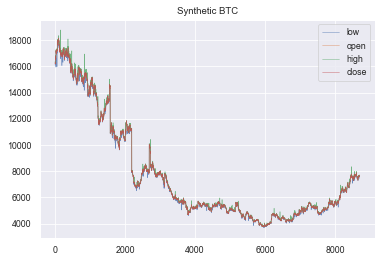

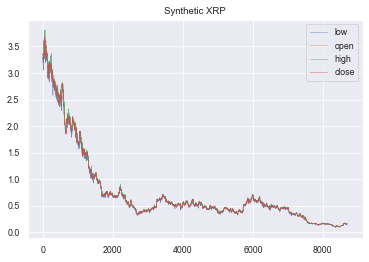

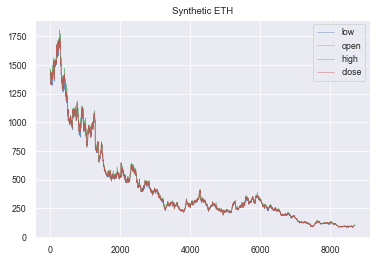

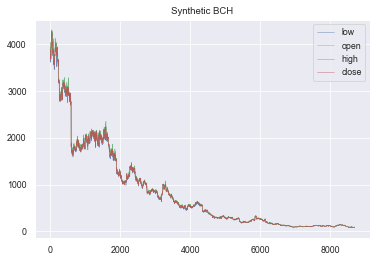

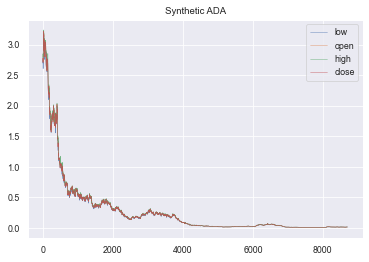

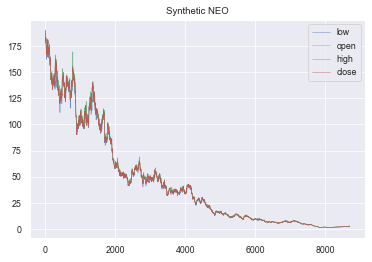

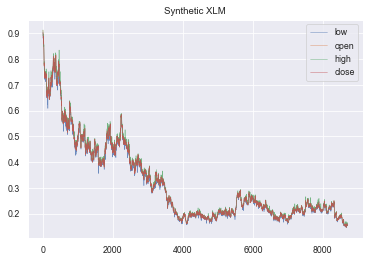

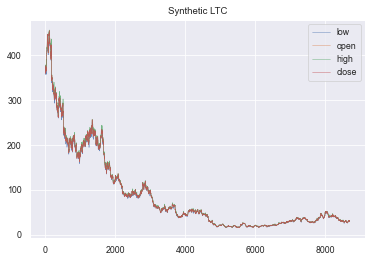

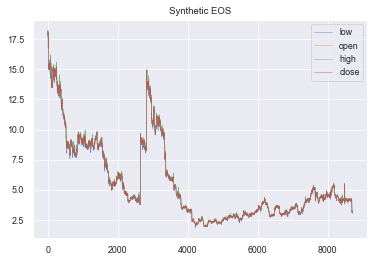

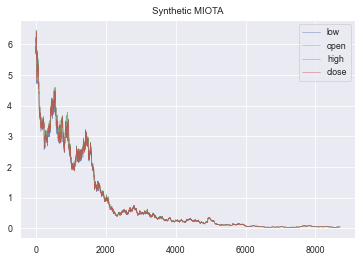

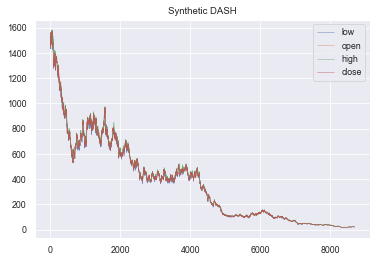

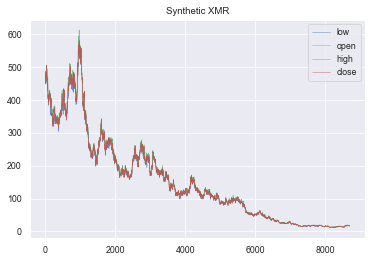

In [9]:
new_portfolio.plot()

In [10]:
new_portfolio.portfolio["BTC"]

,close,high,low,open,mcd,mcd_signal,RSI,SMA_50,SMA_200,stoch_oszillator,stoch_oszillator_signal,Bollinger_middle,Bollinger_low,Bollinger_high
0,16291.071873,16321.884506,16235.956082,16244.606297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16299.093660,16361.305538,16285.540017,16291.071873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16219.271361,16387.003261,16096.830750,16299.093660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16203.113803,16331.217393,16189.210002,16219.271361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16250.504460,16333.551831,16138.003038,16203.113803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,7610.980753,7617.107662,7594.751060,7601.546422,17.014579,21.346827,54.091563,7531.331827,7577.369491,75.039414,76.423054,7611.594118,7567.091407,7656.096829
8696,7625.044944,7649.428259,7597.318268,7610.980753,17.351764,20.547814,56.177457,7534.999249,7578.061782,81.434856,75.741196,7614.439502,7574.357191,7654.521813
8697,7650.209454,7687.377314,7622.604390,7625.044944,19.425624,20.323376,59.705275,7538.564500,7578.716268,84.604190,80.359487,7615.602664,7572.873351,7658.331977
8698,7684.669346,7710.111368,7639.220522,7650.209454,23.578006,20.974302,63.981357,7542.502612,7579.575351,90.368324,85.469123,7616.608810,7568.685038,7664.532582
